In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
class CustomDataset(Dataset):
  def __init__(self, depth, data_type="train"):
    super(CustomDataset, self).__init__()
    self.x = []
    self.y = []

    data = np.genfromtxt("./data.txt", delimiter="")

    for i in range(depth, len(data) - 1):
      if data_type == "train":
        self.x.append(data[i-depth:i,0:4])
        self.y.append(data[i,3])
      elif data_type == "test":
        self.x.append(data[i-depth:i,4:8])
        self.y.append(data[i,7])
      else:
        raise Exception("Invalid data type. Choose either train or test.")
      
    self.x = torch.tensor(np.array(self.x)).float()
    self.y = torch.tensor(np.array(self.y)).float()

    # Max-Min Scaling
    self.data_max = torch.tensor(data).float().max()
    self.data_min = torch.tensor(data).float().min()

    self.x = (self.x - self.data_min) / (self.data_max - self.data_min)
    self.y = (self.y - self.data_min) / (self.data_max - self.data_min)
    
  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def rescale(self, data):
    return data * (self.data_max - self.data_min) + self.data_min

# load the data
dataset = CustomDataset(depth=5, data_type="train")
dataloader = DataLoader(dataset, batch_size = 32)

In [3]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    # input size, hidden size
    self.input_size = input_size
    self.hidden_size = hidden_size

    # gate size
    gate_size = 4 * hidden_size

    # weight
    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    # bias
    self.b = nn.Parameter(torch.Tensor(gate_size))

    # weight initialization
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

  def forward(self, x):
    # B : batch size, L : sequence length(depth)
    B, L = x.size(0), x.size(1)

    output = []

    # initial values
    h0 = torch.zeros(B, self.hidden_size)
    c0 = torch.zeros(B, self.hidden_size)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + h0 @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * c0 + it + gt
      ht = ot * torch.tanh(c0)

      # save as B x 1 x h
      output.append(ht.unsqueeze(1))

    # save as B x L x h
    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [4]:
class SingleStepPrediction(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SingleStepPrediction, self).__init__()

    #self.lstm = CustomLSTM(input_size, hidden_size)
    self.lstm = nn.LSTM(input_size, hidden_size, 1, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, (ht, ct) = self.lstm(x)
    output = self.fc(ht)
    return output

In [5]:
model = SingleStepPrediction(input_size=4, hidden_size=4)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


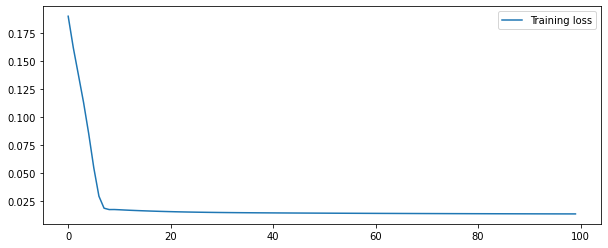

In [6]:
train_history = np.zeros(100)

for epoch in range(100):
  avg_loss = 0
  for i, data in enumerate(dataloader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss/32
  train_history[epoch] = avg_loss

fig = plt.figure(figsize=(10, 4))
plt.plot(train_history, label='Training loss')
plt.legend()
plt.show()

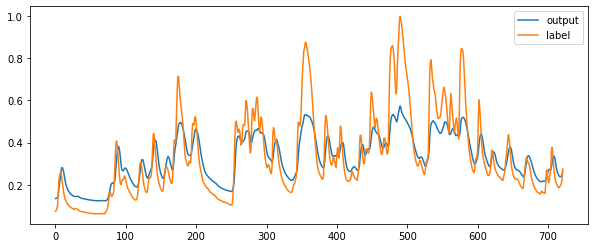

In [7]:
dataset = CustomDataset(depth=5, data_type="test")

p1 = []
p2 = []

for i in range(len(dataset)):
  x, y = dataset.__getitem__(i)
  x = torch.reshape(x, (1, 5, 4))
  output = model(x)
  output = torch.reshape(output, (1,))
  p1.append(output.detach().numpy())
  p2.append(y.detach().numpy())

fig = plt.figure(figsize=(10, 4))
plt.plot(p1, label="output")
plt.plot(p2, label="label")
plt.legend()
plt.show()